# Learning Objectives

Use few-shot prompting to build LLM applications for generation tasks.


# Setup

In [ ]:
!pip install -q openai==1.23.2 datasets==2.19.1 evaluate==0.4.2 bert-score==0.3.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd

from openai import AzureOpenAI
from datasets import load_dataset
from google.colab import userdata
from evaluate import load
from tqdm import tqdm

In [ ]:
azure_api_key = userdata.get('azure_api_key')

In [ ]:
client = AzureOpenAI(
  azure_endpoint = "https://gen-ai-teaching-004.openai.azure.com/",
  api_key=azure_api_key,
  api_version="2024-02-01"
)

In [ ]:
model_name = 'gpt-35-turbo' # deployment name

# Text - Text Generation Tasks

## Overview

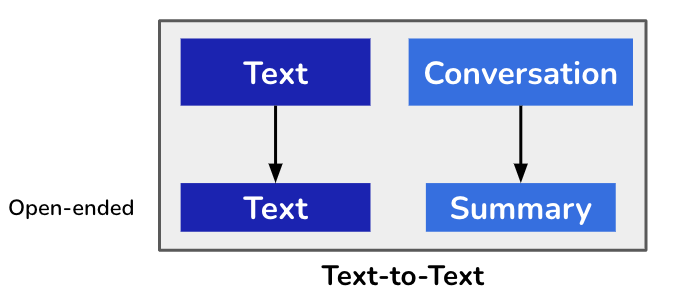

Text-to-Text generation problems are another class of important problems that LLMs solve effectively. In this notebook, we present an approach to design and evaluate prompts for text-to-text tasks using summarization as an example. The approach followed in this notebook can be extended to any other text-to-text task as well.

We begin by presenting a workflow for prompt design and evaluation for text generation tasks.

## Workflow

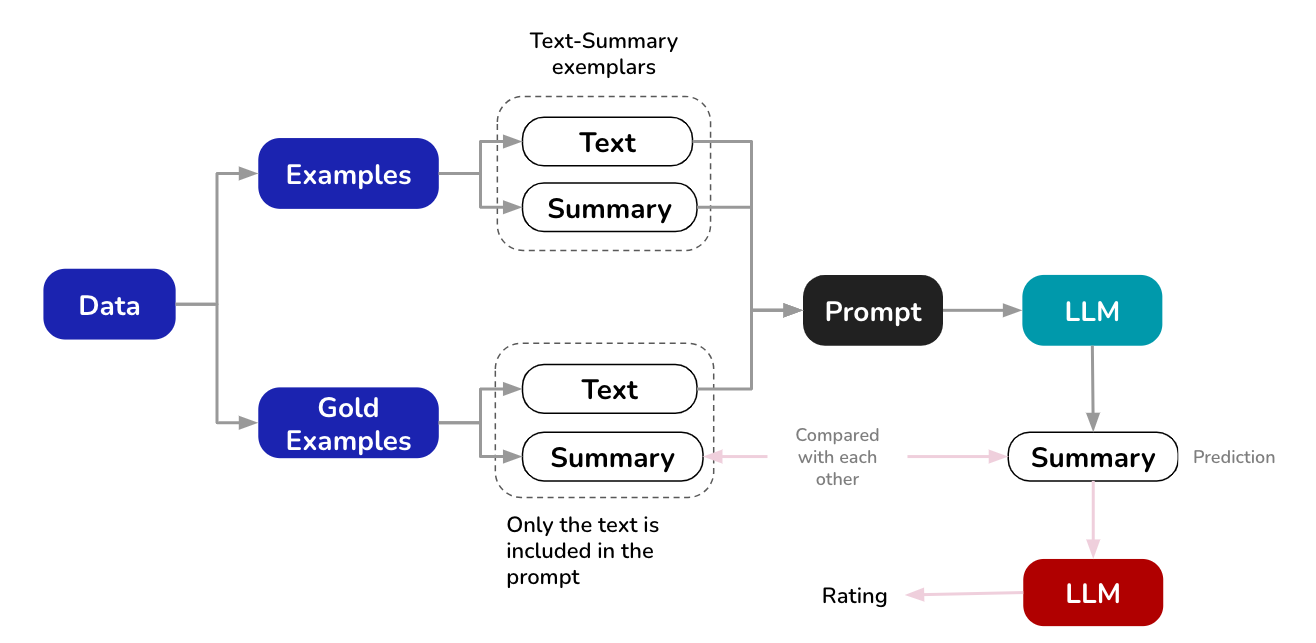

As indicated in the above figure, the data used to achieve text generation tasks comprises examples and gold examples. Examples are input-output exemplars included in the prompt to prime it for expected output generation. Gold examples are inputs for which we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics on the set of gold examples. Unlike classification though, here we have to contend with subjective output. This complicates the evaluation process (including the difficulty in collecting human generated baselines), and it is common to use LLMs to evaluate the quality of outputs (referred to as LLM-as-a-judge).  

## Evaluation

Given the subjective nature of text generation, there are two ways in which generation tasks could be evaluated.

- When human annotations are available, evaluation is done using BERTScore. BERTScore is an automatic evaluation metric for text generation tasks that leverages the pre-trained contextual embeddings from BERT to compute the semantic similarity between the generated text (candidate) and the reference text, rather than relying on exact token matches.

- When human annotations are not available, we use another LLM to rate the performance of the LLM used in the generation task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

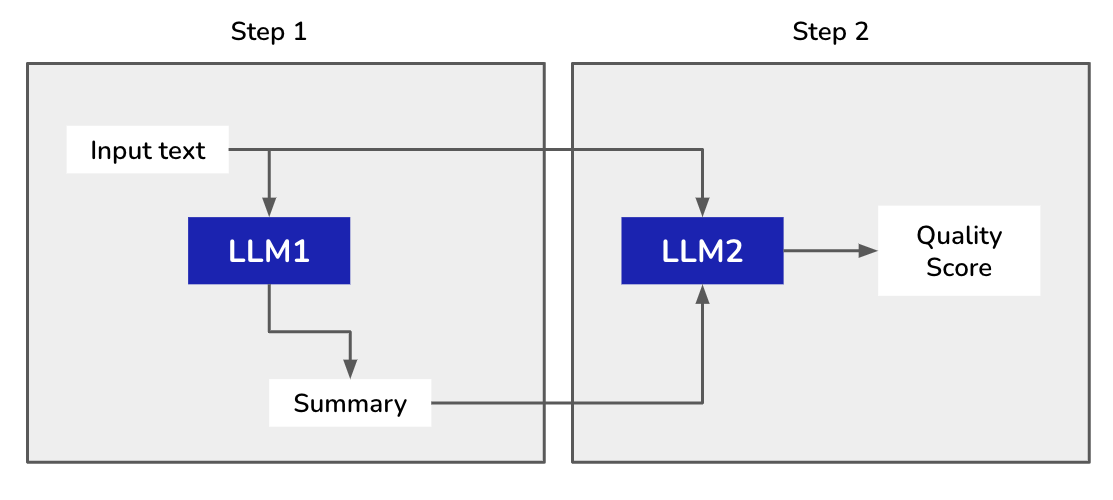

Let us now implement this workflow for diaogue summarization on a sample of conversations.

# Summarization

## Business Use Case

Summarizing customer interactions with sales employees or interactions between employees can be a source of valuable information. Customer interactions can point towards pain points or positives about a product. Summarizing meetings and deriving action points from meetings improves organizational efficiency. There are several other situations where text generation is of value for the enterprise (se elist below).


1. *Customer Support Automation:*
   - *Input:* Customer inquiries or complaints in text form.
   - *Output:* Automated responses or suggested solutions generated in response to customer queries.

2. *Email Autoresponders:*
   - *Input:* Incoming emails.
   - *Output:* Automatic email responses generated based on predefined rules or machine learning algorithms.

3. *Content Generation:*
   - *Input:* Prompts or specifications for content creation.
   - *Output:* Generated articles, stories, or creative pieces in response to the input.

4. *Code Generation:*
    - *Input:* Descriptions or requirements for a program.
    - *Output:* Automatically generated code based on the input specifications.

5. *Automated Report Generation:*
    - *Input:* Data sets or parameters.
    - *Output:* Automatically generated reports or summaries describing the data.

6. *Social Media Posting:*
    - *Input:* Drafts or prompts for social media posts.
    - *Output:* Published social media content.

## Prompt Design

We will design a few-shot prompt for summarization. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

In [ ]:
dataset = load_dataset("pgurazada1/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

**Assembling the prompt**

Let us now assemble 4 examples from this dataset of 32 dialogue examples. We also collect the 32 gold examples.

In [ ]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

In [ ]:
examples_df = dialogue_summary_examples_df.sample(4)

In [ ]:
examples_df

dialogue  \
26  #Person1#: I haven't seen you in a while. How ...   
11  #Person1#: The performance is amazing. I'm cur...   
15  #Person1#: Excuse me mam, can you tell me how ...   
28  #Person1#: I am here to sign my escrow papers....   

                                              summary  
26  Both #Person1# and #Person2# need to find a jo...  
11  #Person1# thinks the performance is amazing an...  
15  #Person1# asks #Person2# how to get to Son Col...  
28  #Person2# helps #Person1# every step of signin...

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [ ]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row[0])
    print('Example Summary:')
    print(row[1])
    break

Example Dialogue:
#Person1#: I haven't seen you in a while. How have you been?
#Person2#: Things are going fairly well. How about you?
#Person1#: Well, I'm hanging in there, but I lost my job and need to find another one quickly.
#Person2#: I am looking for a job myself. What were you thinking of doing next?
#Person1#: I am just trying to find something that will pay the bills until this bad economy passes by.
#Person2#: Have you gotten any interviews yet?
#Person1#: No, I haven't been out on one interview yet.
#Person2#: Have you thought about the electrician program over there?
#Person1#: I think that I might be interested in that position.
#Person2#: I think we should go over there and see if we can apply for that program.
Example Summary:
Both #Person1# and #Person2# need to find a job to go through the bad economy and #Person2# suggests applying for the electrician program together.


In [ ]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [ ]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [ ]:
for index, row in examples_df.iterrows():
    user_input_example = row[0]
    assistant_output_example = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [ ]:
few_shot_prompt

[{'role': 'system',
  'content': '\nSummarize the dialogue mentioned in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': "#Person1#: I haven't seen you in a while. How have you been?\n#Person2#: Things are going fairly well. How about you?\n#Person1#: Well, I'm hanging in there, but I lost my job and need to find another one quickly.\n#Person2#: I am looking for a job myself. What were you thinking of doing next?\n#Person1#: I am just trying to find something that will pay the bills until this bad economy passes by.\n#Person2#: Have you gotten any interviews yet?\n#Person1#: No, I haven't been out on one interview yet.\n#Person2#: Have you thought about the electrician program over there?\n#Person1#: I think that I might be interested in that position.\n#Person2#: I think we should go over there and see if we can apply for that program."},
 {'role': 'assistant',
  'content': 'Both #Person1# and #Person2# need to find a job to go through the b

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we need gold examples to get a baseline estimate.

## Evaluation

In [ ]:
predictions, ground_truths = [], []

In [ ]:
for index, row in tqdm(dialogue_summary_gold_examples_df.iterrows()):
    gold_dialogue = row[0]
    gold_summary = row[1]

    user_input = [{'role':'user', 'content': gold_dialogue}]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=few_shot_prompt + user_input
        )

        predictions.append(response.choices[0].message.content)
        ground_truths.append(gold_summary)
    except Exception as e:
        print(e) # Log error and continue
        continue

32it [00:35,  1.12s/it]


We now have a set of summaries from the LLM and we want to understand if the summary is a good reflection of the content of the dialogue. To accomplish this, we could use a more powerful model to act as a judge. We also have human baseline summaries for the same conversation and we could use BERTScore to compare the predictions and ground truths. Let us now run evaluations using both these methods.

**BERTScore**

In [ ]:
bertscore = load("bertscore")

In [ ]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sum(results['f1'])/len(results['f1'])

0.8947776015847921

The above score indicates that the summarization was of very high quality,

**LLM-as-a-judge**

A general prompt that can be used when LLMs are used as judges is presented below. To save cost we are using GPT 3.5 turbo itself as the rater model. Empirically, it is demonstrated that GPT 4 is a very good rater model.

In [ ]:
rater_model = model_name

In [ ]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The summary should cover all the aspects that are majorly being discussed in the dialogue.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
"""

Notice how the rubric is clearly defined. Also the metric used to judge the output is clearly delineated. This prompt can be readily adapted to create multiple raters,e ach focusing on one metric.

In [ ]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

In [ ]:
ratings = []

In [ ]:
for gold_dialogue, prediction in tqdm(zip(dialogue_summary_gold_examples_df.dialogue, predictions)):

    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                dialogue=gold_dialogue,
                summary=prediction
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )

    ratings.append(response.choices[0].message.content)

32it [02:14,  4.19s/it]


In [ ]:
pd.DataFrame(
    {'dialogue': dialogue_summary_gold_examples_df.dialogue,
     'prediction': predictions,
     'rating': ratings
     }
)

dialogue  \
0   #Person1#: do you have any plans for dinner to...   
1   #Person1#: Are you an art aficionado?\n#Person...   
2   #Person1#: Sally,here is a letter for us. It's...   
3   #Person1#: So, did I tell you about my New Yea...   
4   #Person1#: I'm coming to pick up my ticket. Th...   
5   #Person1#: Hi, Dan, I'm calling to check on th...   
6   #Person1#: Tom, I've got good news for you.\n#...   
7   #Person1#: How did your company's fundraiser g...   
8   #Person1#: OK, Mrs Thomas. I finished cleaning...   
9   #Person1#: Mr. Wilson. We are very regretful a...   
10  #Person1#: Hi, Fanny.\n#Person2#: Hi, Andy.\n#...   
11  #Person1#: You mustn't touch the wet paint, Bi...   
12  #Person1#: Tomorrow is Mike's birthday. I have...   
13  #Person1#: Is anybody in?\n#Person2#: How can ...   
14  #Person1#: Would you like to go to the party t...   
15  #Person1#: Welcome to Danny's, may I take your...   
16  #Person1#: Good morning. What can I do for you...   
17  #Person1#: Excuse me, could you tell me where ...   
18  #Person1#: Excuse me. What's happened? What pl...   
19  #Person1#: It's partly your own fault. You sho...   
20  #Person1#: Hi, I made a reservation for a mid-...   
21  #Person1#: I think spring is finally here.\n#P...   
22  #Person1#: Would you please recommend some Chi...   
23  #Person1#: John? It's Susan Miller.\n#Person2#...   
24  #Person1#: Were you born in Los Angeles?\n#Per...   
25  #Person1#: Well, I'd better get back to work. ...   
26  #Person1#: Hello, this is Francis.\n#Person2#:...   
27  #Person1#: Brian, do you know how to speak Eng...   
28  #Person1#: Honey, of course I forgive you! I l...   
29  #Person1#: My throat is really dry.\n#Person2#...   
30  #Person1#: Hello? Hello?\n#Person2#: ...\n#Per...   
31  #Person1#: I have to go up to London for a cou...   

                                           prediction  \
0   #Person1# suggests making dinner together inst...   
1   #Person1# and #Person2# discuss their interest...   
2   #Person1# receives a letter from Tom addressed...   
3   #Person1# tells #Person2# about their New Year...   
4   #Person1# wants to pick up their ticket and pr...   
5   #Person1# calls #Person2# to inquire about the...   
6   #Person1# informs #Person2# that their novel h...   
7   #Person2# describes how their company's fundra...   
8   #Person1# helps #Person2# with cleaning up the...   
9   #Person1# apologizes for the mistakes in the g...   
10  #Person2# tells #Person1# about a bad dream th...   
11  #Person1# warns #Person2# not to touch the wet...   
12  #Person1# and #Person2# have both received an ...   
13  #Person1# has a headache and #Person2# takes t...   
14  #Person1# invites #Person2# to a party being h...   
15  #Person2# orders a turkey sandwich with cheese...   
16  #Person2# complains about the noise in their c...   
17  #Person1# asks #Person2# where Peking Universi...   
18  #Person1# asks about the plane taking off toni...   
19  #Person1# blames #Person2# for letting someone...   
20  #Person1# made a reservation for a mid-size ve...   
21  #Person1# and #Person2# agree that spring is h...   
22  #Person1# asks for a recommendation of Chinese...   
23  #Person1# calls #Person2# to ask about the loc...   
24  #Person2# was born in Chicago and moved to Los...   
25  #Person1# and #Person2# both have work to do a...   
26  #Person1# and #Person2# have a conversation ab...   
27  #Person1# asks #Person2# if they know how to s...   
28  #Person1# forgives #Person2# for not contactin...   
29  #Person1# mentions having a dry throat and #Pe...   
30  #Person1# answers a call from an unknown calle...   
31  #Person1# invites #Person2# to go to London wi...   

                                               rating  
0   Evaluation Criteria:\n1. Does the summary incl...  
1   To evaluate the summary as per the metric, we ...  
2   To evaluate the summary as per the metric, we ...  
3   Steps to evaluate the summary:\n\n1. Identify ...  
4

These detailed ratings could be used to diagnose issues with the prompt or the model used.